In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# VAEs are similar to auto encoders ( but instead of compressing the image randomly, the image is compressed as a statistical representation of mean and variance)
# Then a normal distribution of latent space is created
# A random point z is taken so that its similar to the input image(close distance between them in the latent space)
# The decoder uses the point to construct the output image which will be similar to the input image
# 2 losses : Reconstruction loss to make the output image similar to the input image , Regularization loss to prevent overfitting on the training data

In [3]:
# Will be using MNIST dataset to train the VAE
# 3 parts involved in building the VAE : Encoder , Sampling layer to take the random point, Decoder

In [4]:
from keras.layers import Dense, Flatten, Conv2D, Input
from keras.models import Model

In [5]:
# Encoder network

latent_dim = 2 # Dimension of latent space (2D)

encoder_inputs = Input(shape=(28,28,1)) # We know that the MNIST dataset has images of shape 28,28,1
conv_layer1 = Conv2D(32,3,activation="relu",strides=2,padding="same")(encoder_inputs) # Using strides instead of max pooling ( Because strides are more useful than pooling when the information about the location of the contents in the image is important)
conv_layer2 = Conv2D(64,3,activation="relu",strides=2,padding="same")(conv_layer1)

flatten_layer = Flatten()(conv_layer2)
dense_layer1 = Dense(16,activation="relu")(flatten_layer)
z_mean_layer = Dense(latent_dim,name="z_mean")(dense_layer1) # Layer for z_mean 
z_variance_layer = Dense(latent_dim,name="z_variance")(dense_layer1) # Layer for z_variance

encoder = Model(encoder_inputs,[z_mean_layer,z_variance_layer],name="encoder")

In [6]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [7]:
# Sampling function for randomly picking a point in the latent space

class Sampler(keras.layers.Layer):
    def call(self,z_mean_layer,z_variance_layer):
        batch_size = tf.shape(z_mean_layer)[0]
        z_size = tf.shape(z_mean_layer)[1]
        epsilon = tf.random.normal(shape=(batch_size,z_size)) # Drawing a batch of random normal vectors
        return z_mean_layer + tf.exp(0.5 * z_variance_layer) * epsilon # Returning the random point 

In [8]:
from keras.layers import Reshape,Conv2DTranspose

In [9]:
# Decoder network

latent_inputs = Input(shape=(latent_dim,))
dense_layer1 = Dense(7*7*64,activation="relu")(latent_inputs) # Produce same number of coefficients that we had at the level of flatten layer in encoder
reshape_layer = Reshape((7,7,64))(dense_layer1) # Reverting the flatten layer functionality in the encoder(7*7*64 is taken from the output shape of the Conv layer before flattening)

# In encoder, first a 32 unit layer, then a 64 unit layer, so here it will be in reverse (first a 32 unit layer, then a 64 unit layer)
conv_transpose_layer1 = Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(reshape_layer) # Reverting the convolution layer functionality in the encoder
conv_transpose_layer2 = Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(conv_transpose_layer1) # Reverting the convolution layer functionality in the encoder
decoder_output_layer = Conv2D(1,3,activation="sigmoid",padding="same")(conv_transpose_layer2) # Output ends with the same shape as before (28,28,1)

decoder = Model(latent_inputs,decoder_output_layer,name="decoder")

In [10]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [11]:
# Self supervised learning --> Input is similar to target ( VAE is trained as self supervised training )
# In case of self supervised training, its common to sub class the model and implement a custom train step to specify the new training logic

In [12]:
class VAE(keras.models.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") # Kullback-Leibler divergance for regularization loss

    @property
    def metrics(self): # List of metrics in the metrics property to enable the model to reset them after each epoch
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean , z_variance = self.encoder(data)
            z = self.sampler(z_mean,z_variance)
            reconstruction = self.decoder(z)
            
            # Summing the reconstruction loss over the spatial dimensions(axes 1 and 2) and take its mean over the batch dimension
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data,reconstruction),
                    axis=(1,2)
                )
            )

            # Calculating the Kullback-Leibler divergence loss
            kl_loss = - 0.5 * (1 + z_variance - tf.square(z_mean) - tf.exp(z_variance))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        trainable_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads = tape.gradient(total_loss,trainable_vars)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
            
        return {
            "total_loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "kl_loss":self.kl_loss_tracker.result()
        }


In [13]:
# We don't need to pass any target data(because its similar to input data)

(x_train, _) , (x_test, _) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test],axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype("float32") / 255

vae = VAE(encoder,decoder)
vae.compile(optimizer = keras.optimizers.Adam() ,run_eagerly = True)
vae.fit(mnist_digits,epochs=30,batch_size=128)

Epoch 1/30
547/547 [==============================] - 46s 71ms/step - total_loss: 211.5790 - reconstruction_loss: 209.7859 - kl_loss: 1.7927
Epoch 2/30
547/547 [==============================] - 38s 70ms/step - total_loss: 168.9058 - reconstruction_loss: 165.7792 - kl_loss: 3.1266
Epoch 3/30
547/547 [==============================] - 38s 70ms/step - total_loss: 163.0870 - reconstruction_loss: 160.0491 - kl_loss: 3.0378
Epoch 4/30
547/547 [==============================] - 40s 72ms/step - total_loss: 159.5287 - reconstruction_loss: 156.4094 - kl_loss: 3.1193
Epoch 5/30
547/547 [==============================] - 39s 72ms/step - total_loss: 157.0598 - reconstruction_loss: 153.8757 - kl_loss: 3.1840
Epoch 6/30
547/547 [==============================] - 26s 48ms/step - total_loss: 155.4234 - reconstruction_loss: 152.1972 - kl_loss: 3.2262
Epoch 7/30
547/547 [==============================] - 19s 35ms/step - total_loss: 154.3284 - reconstruction_loss: 151.0729 - kl_loss: 3.2554
Epoch 8/30
54

1/1 [==============================] - 0s 19ms/step


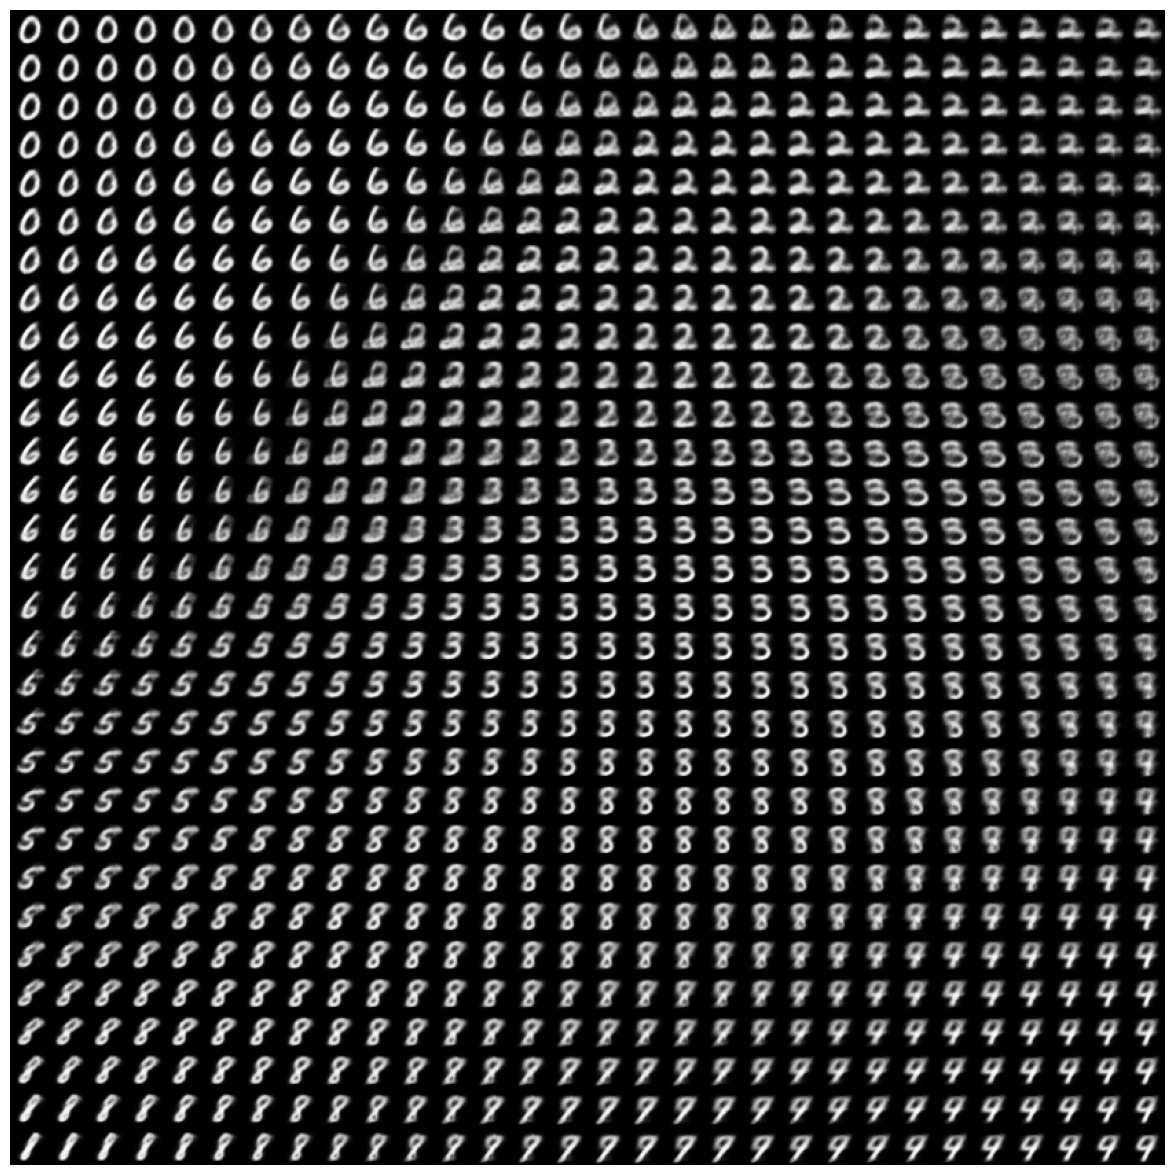

In [15]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
        i * digit_size : (i + 1) * digit_size,
        j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")